# Introduction #

Welcome to this Notebook ! Today you will play with some tools used by quants for options pricing. We will mainly work with call and puts, the usual derivatives you can have in the market.
This notebook will be divided into two main sections :
- Monte Carlo and analytical pricing in Black&Scholes framework
- Introduction to advanced solutions

The aim of this notebook is to introduce you to the beauty of the math behind option pricing. If you want further details, we encourage you to go to these ressources :
- LACTU2170 : Stochastic finance
- LACTU2240 : Advanced processes in life-insurance engineering
- LLSMS2225 : Derivatives Pricing
- Hull - Options, futures and other derivatives

In [3]:
# You can keep this section closed (it contains all the imports)
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, FloatSlider, IntSlider
import scipy.stats as si
import ipywidgets as widgets
from IPython.display import display
from scipy.stats import norm, skew, kurtosis
from scipy.optimize import minimize
import pandas as pd


## Section 4 : Monte-Carlo and analytical pricing in B&S framework ##

### Ex4.1. Monte-Carlo simulation on $\mathbb{P}$ and $\mathbb{Q}$ ###

Here, you will simulate one sample path of the evolution of a Stock price during one year.
We recall the equations for the dynamics of the log-returns : 
\begin{align*}
     & \text{under $\mathbb{Q}$ : }\frac{dS_t}{S_t}   = \left( r - \frac{\sigma^2}{2}\right)dt + \sigma dW^{\mathbb{Q}}_t \\
     & \text{under $\mathbb{P}$ : }\frac{dS_t}{S_t}   = \left( \mu \right)dt + \sigma dW^{\mathbb{P}}_t
\end{align*}

In the following plot, you can see that we can barely make the difference between the two simulations. You can think "Why should I use one measure or another ?". We will answer this later but I'm glad you asked !

In [4]:
# You can keep this section closed (it contains boring code)
def monte_carlo_simulation(num_paths=1000, T=1, dt=1/252, S0=100, mu=0.1, sigma=0.2, r=0.05):
    """
    Simulates stock prices under both the real-world measure P and risk-neutral measure Q.

    Parameters:
        num_paths (int): Number of Monte Carlo paths.
        T (float): Time horizon in years.
        dt (float): Time step (daily = 1/252).
        S0 (float): Initial stock price.
        mu (float): Drift under real-world measure P.
        sigma (float): Volatility of the stock.
        r (float): Risk-free rate.

    Returns:
        None (plots the simulation).
    """
    #np.random.seed(42)  # For reproducibility

    # Number of time steps
    num_steps = int(T / dt)

    # Time array
    time = np.linspace(0, T, num_steps + 1)

    # Initialize stock price arrays
    S_P = np.zeros((num_paths, num_steps + 1))
    S_Q = np.zeros((num_paths, num_steps + 1))

    # Set initial stock prices
    S_P[:, 0] = S0
    S_Q[:, 0] = S0

    # Simulate paths
    for t in range(1, num_steps + 1):
        dW = np.random.normal(0, 1, num_paths)  # Random Walk
        S_P[:, t] = S_P[:, t - 1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * dW)
    for t in range(1, num_steps + 1):
        dW = np.random.normal(0, 1, num_paths)  # Random Walk
        S_Q[:, t] = S_Q[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * dW)

    # Plot one path from each measure
    plt.figure(figsize=(10, 6))
    plt.plot(time, S_P[0], label="Real-World Measure (P)", color="blue")
    plt.plot(time, S_Q[0], label="Risk-Neutral Measure (Q)", color="red")
    plt.xlabel("Time (Years)")
    plt.ylabel("Stock Price")
    plt.title("Monte Carlo Simulation of Stock Price under P and Q")
    plt.legend()
    plt.grid()
    plt.show()

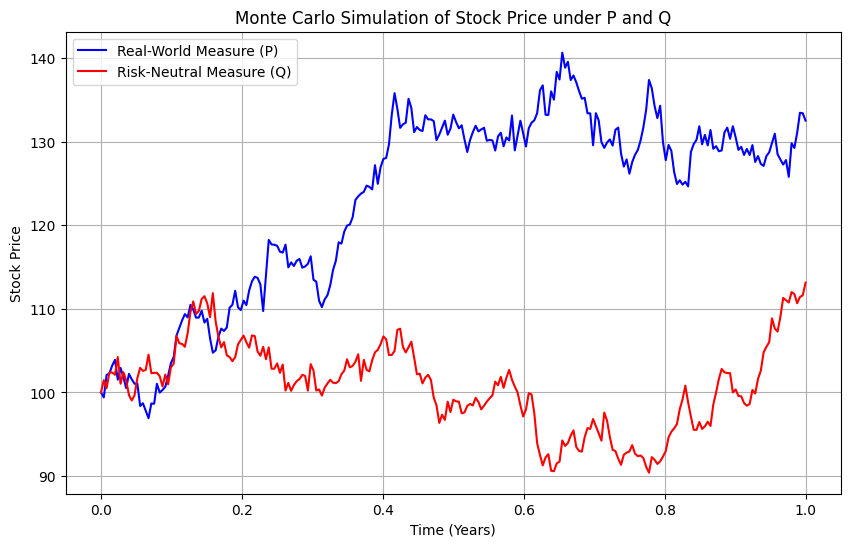

In [10]:
monte_carlo_simulation(num_paths=1, T=1, dt=1/252, S0=100, mu=0.1, sigma=0.2, r=0.05)

### Ex4.2 : More paths, more simulations ###

If you understand what you'll see in the next plot, you're a genius. If not, that's completely fine. Next plot is to show you what quants need to do when using simulations to price options : they need to do a lot of simulations if they want to obtain precise prices ! 


You will plot about 1000 paths. Eventhough it seems like a lot, we usually perform 40 000 simulations of that kind. If you try to simulate that many paths... Well your computer is going to heat and that will take time. Now you understand why we need analytical solutions.

In [11]:
# You can keep this section closed (boring code)
def monte_carlo_simulation(num_paths=1000, T=1, dt=1/252, S0=100, mu=0.1, sigma=0.2, r=0.05):
    """
    Simulates stock prices under both the real-world measure P and risk-neutral measure Q.

    Parameters:
        num_paths (int): Number of Monte Carlo paths.
        T (float): Time horizon in years.
        dt (float): Time step (daily = 1/252).
        S0 (float): Initial stock price.
        mu (float): Drift under real-world measure P.
        sigma (float): Volatility of the stock.
        r (float): Risk-free rate.

    Returns:
        None (plots the simulation).
    """
    np.random.seed(42)  # For reproducibility

    # Number of time steps
    num_steps = int(T / dt)

    # Time array
    time = np.linspace(0, T, num_steps + 1)

    # Initialize stock price arrays
    S_P = np.zeros((num_paths, num_steps + 1))
    S_Q = np.zeros((num_paths, num_steps + 1))

    # Set initial stock prices
    S_P[:, 0] = S0
    S_Q[:, 0] = S0

    # Simulate paths
    for t in range(1, num_steps + 1):
        dW = np.random.normal(0, 1, num_paths)  # Random Walk
        S_P[:, t] = S_P[:, t - 1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * dW)
    for t in range(1, num_steps + 1):
        dW = np.random.normal(0, 1, num_paths)  # Random Walk
        S_Q[:, t] = S_Q[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * dW)

    # Plot all paths from each measure
    plt.figure(figsize=(10, 6))
    for i in range(num_paths):
        plt.plot(time, S_P[i], color="blue", alpha=0.3, linewidth=0.5)
        plt.plot(time, S_Q[i], color="red", alpha=0.3, linewidth=0.5)
    plt.xlabel("Time (Years)")
    plt.ylabel("Stock Price")
    plt.title("Monte Carlo Simulation of Stock Price under P and Q (100 Paths)")
    plt.grid()
    plt.show()


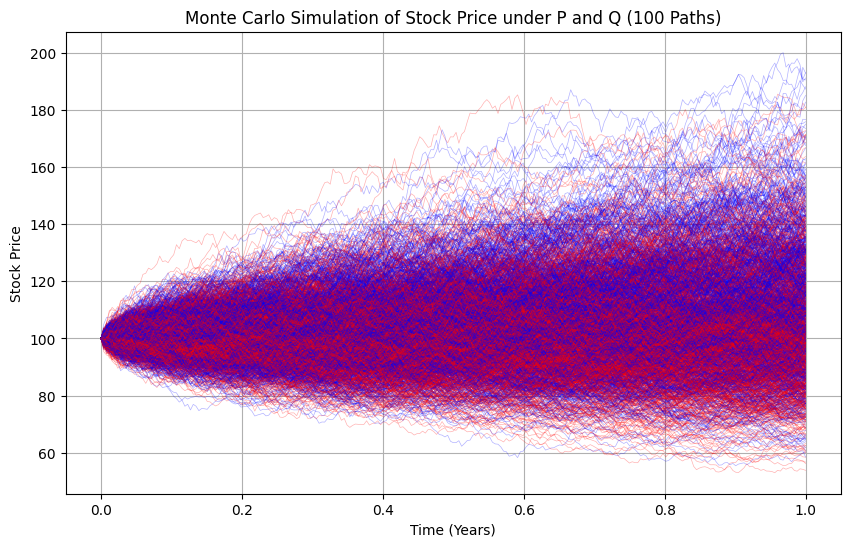

In [12]:
monte_carlo_simulation(num_paths=1000, T=1, dt=1/252, S0=100, mu=0.1, sigma=0.2, r=0.05)

### Ex4.3 : Quantiles ###
What we can do in order to have a better understanding of the differrence between simulations under different measures, we can analyze the quantiles. You know, that thing you hated in your first probabilities classes... 

Try to modify $\mu$ and $r$, and observe what happens at the trends and the final values (what values take the means at the end of the year ?)

In [13]:
# You can keep this section closed (boring code)
def monte_carlo_simulation(num_paths=1000, T=1, dt=1/252, S0=100, mu=0.1, sigma=0.2, r=0.05, PlotOption = "Paths"):
    """
    Simulates stock prices under both the real-world measure P and risk-neutral measure Q.

    Parameters:
        num_paths (int): Number of Monte Carlo paths.
        T (float): Time horizon in years.
        dt (float): Time step (daily = 1/252).
        S0 (float): Initial stock price.
        mu (float): Drift under real-world measure P.
        sigma (float): Volatility of the stock.
        r (float): Risk-free rate.

    Returns:
        None (plots the simulation).
    """
    np.random.seed(42)  # For reproducibility

    # Number of time steps
    num_steps = int(T / dt)

    # Time array
    time = np.linspace(0, T, num_steps + 1)

    # Initialize stock price arrays
    S_P = np.zeros((num_paths, num_steps + 1))
    S_Q = np.zeros((num_paths, num_steps + 1))

    # Initialize Quantiles arrays
    P_Mean = np.zeros(num_steps)
    P_Quantil05 = np.zeros(num_steps)
    P_Quantil10 = np.zeros(num_steps)
    P_Quantil90 = np.zeros(num_steps)
    P_Quantil95 = np.zeros(num_steps)

    Q_Mean = np.zeros(num_steps)
    Q_Quantil05 = np.zeros(num_steps)
    Q_Quantil10 = np.zeros(num_steps)
    Q_Quantil90 = np.zeros(num_steps)
    Q_Quantil95 = np.zeros(num_steps)

    # Set initial stock prices
    S_P[:, 0] = S0
    S_Q[:, 0] = S0

    # Simulate paths
    for t in range(1, num_steps + 1):
        dW = np.random.normal(0, 1, num_paths)  # Random Walk
        Return = mu * dt + sigma * np.sqrt(dt) * dW
        S_P[:, t] = S_P[:, t - 1] * np.exp(Return)
    for t in range(1, num_steps + 1):
        dW = np.random.normal(0, 1, num_paths)  # Random Walk
        Return = (r - 0.5 * sigma **2) * dt + sigma * np.sqrt(dt) * dW
        S_Q[:, t] = S_Q[:, t - 1] * np.exp(Return)

    # Extract Quantiles from paths
    for i in range(num_steps):
        P_Sub = S_P[:, i]
        Q_Sub = S_Q[:, i]

        P_Mean[i] = np.quantile(P_Sub, 0.5)
        P_Quantil05[i] = np.quantile(P_Sub, 0.05)
        P_Quantil10[i] = np.quantile(P_Sub, 0.1)
        P_Quantil90[i] = np.quantile(P_Sub, 0.9)
        P_Quantil95[i] = np.quantile(P_Sub, 0.95)

        Q_Mean[i] = np.quantile(Q_Sub, 0.5)
        Q_Quantil05[i] = np.quantile(Q_Sub, 0.05)
        Q_Quantil10[i] = np.quantile(Q_Sub, 0.1)
        Q_Quantil90[i] = np.quantile(Q_Sub, 0.9)
        Q_Quantil95[i] = np.quantile(Q_Sub, 0.95)
    
    if PlotOption == "Paths":
        # Plot all paths from each measure
        plt.figure(figsize=(10, 6))
        for i in range(num_paths):
            plt.plot(time, S_P[i], color="blue", alpha=0.3, linewidth=0.5)
            plt.plot(time, S_Q[i], color="red", alpha=0.3, linewidth=0.5)
        plt.xlabel("Time (Years)")
        plt.ylabel("Stock Price")
        plt.title("Monte Carlo Simulation of Stock Price under P and Q (100 Paths)")
        plt.grid()
        plt.show()
    elif PlotOption == "Quantiles":
        # Plot Quantiles for P and Q
        plt.figure(figsize=(10,6))
        plt.plot(time[:-1],P_Mean, color = "blue", alpha = 1, linewidth = 1, label = "Mean for P")
        plt.plot(time[:-1],Q_Mean, color = "red", alpha = 1, linewidth = 1, label = "Mean for Q")

        plt.plot(time[:-1],P_Quantil05, color = "m", alpha = 1, linewidth = 1, label = "Quantiles for P")
        plt.plot(time[:-1],P_Quantil10, color = "m", alpha = 1, linewidth = 1)
        plt.plot(time[:-1],P_Quantil90, color = "m", alpha = 1, linewidth = 1)
        plt.plot(time[:-1],P_Quantil95, color = "m", alpha = 1, linewidth = 1)

        plt.plot(time[:-1],Q_Quantil05, color = "c", alpha = 1, linewidth = 1, label = "Quantiles for Q")
        plt.plot(time[:-1],Q_Quantil10, color = "c", alpha = 1, linewidth = 1)
        plt.plot(time[:-1],Q_Quantil90, color = "c", alpha = 1, linewidth = 1)
        plt.plot(time[:-1],Q_Quantil95, color = "c", alpha = 1, linewidth = 1)

        plt.xlabel("Time (Years)")
        plt.ylabel("Stock Price")
        plt.title("Quantiles of MC simulations")
        plt.grid()
        plt.legend()
        plt.show()

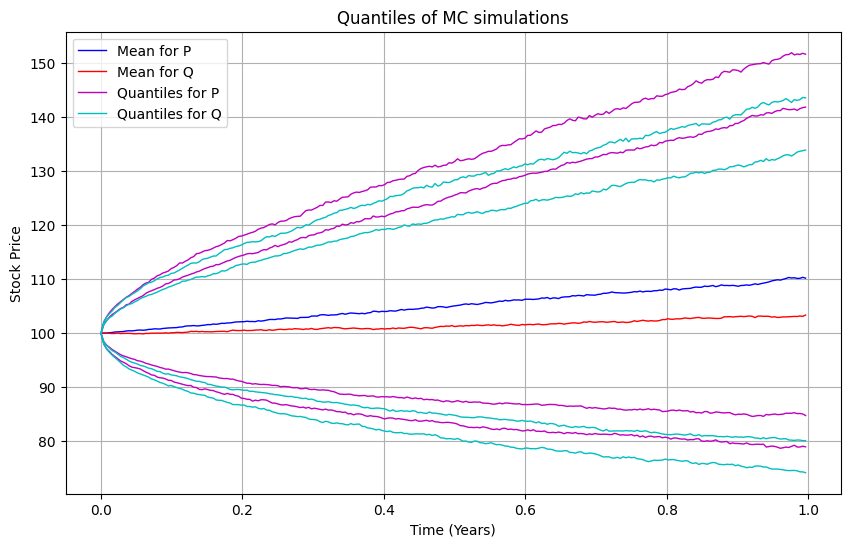

In [17]:
monte_carlo_simulation(num_paths=5000, T=1, dt=1/252, S0=100, mu=0.1, sigma=0.2, r=0.05, PlotOption="Quantiles")

### Ex4.4 : Comparison between MC and analytical solution ###

In this exercise, you will compare two methods : Monte-Carlo simulations and analytical solutions. 


We are trying to find the value of a call. 


Reminder : A call can be expressed as : $\left(S_T - K\right)_+$ 


We want you to play with parameters and answer this question : Is the price closer to the simulations under $\mathbb{P}$ or $\mathbb{Q}$ ?

In [18]:
# You can keep this section closed (boring code)
# Black-Scholes formula
def black_scholes_call(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call_price = S0 * si.norm.cdf(d1) - K * np.exp(-r * T) * si.norm.cdf(d2)
    return call_price

# Monte Carlo simulation
def monte_carlo_call(S0, K, mu, T, r, sigma, num_simulations=100000, measure="Q"):
    np.random.seed(42)  # For reproducibility
    dt = T  # Single-step model for European option
    Z = np.random.randn(num_simulations)  # Standard normal random variables
    if measure == "Q":
        ST = S0 * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)  # Simulated stock prices
    if measure == "P":
        ST = S0 * np.exp(mu * dt + sigma * np.sqrt(dt) * Z)  # Simulated stock prices
    payoff = np.maximum(ST - K, 0)  # Call option payoff
    call_price = np.exp(-r * T) * np.mean(payoff)  # Discounted expectation
    return call_price

# Plot function
def plot_parameter_variation(param_name, param_values, S0, K, T, r, sigma, mu):
    prices = [black_scholes_call(S0 if param_name != 'S0' else val,
                                 K if param_name != 'K' else val,
                                 T if param_name != 'T' else val,
                                 r if param_name != 'r' else val,
                                 sigma if param_name != 'σ' else val)
              for val in param_values]
    
    plt.figure(figsize=(6, 4))
    plt.plot(param_values, prices, label=f"Option Price vs {param_name}")
    plt.xlabel(param_name)
    plt.ylabel("Option Price")
    plt.title(f"Black-Scholes Price as {param_name} Varies")
    plt.legend()
    plt.grid()
    plt.show()

# Interactive UI
def interactive_pricing(S0, K, T, r, sigma, mu):
    bs_price = black_scholes_call(S0, K, T, r, sigma)
    mc_price_Q = monte_carlo_call(S0, K, mu, T, r, sigma, measure="Q")
    mc_price_P = monte_carlo_call(S0, K, mu, T, r, sigma, measure="P")
    
    print(f"Black-Scholes Price: {bs_price:.4f}")
    print(f"Monte Carlo Price under Q: {mc_price_Q:.4f}")
    print(f"Monte Carlo Price under P: {mc_price_P:.4f}")
    
    param_values = np.linspace(0.5 * S0, 1.5 * S0, 50)  # Example range
    #plot_parameter_variation("S0", param_values, S0, K, T, r, sigma, mu)

# Sliders
S0_slider = widgets.FloatSlider(value=100, min=50, max=200, step=1, description='S0')
K_slider = widgets.FloatSlider(value=100, min=50, max=200, step=1, description='K')
T_slider = widgets.FloatSlider(value=1, min=0.1, max=5, step=0.1, description='T')
r_slider = widgets.FloatSlider(value=0.05, min=0.0, max=0.2, step=0.01, description='r')
sigma_slider = widgets.FloatSlider(value=0.2, min=0.1, max=1.0, step=0.01, description='σ')
mu_slider = widgets.FloatSlider(value=0.1, min=-0.1, max=0.3, step=0.01, description='μ')

# Display UI
iu = widgets.interactive(interactive_pricing, S0=S0_slider, K=K_slider, T=T_slider, r=r_slider, sigma=sigma_slider, mu=mu_slider)
display(iu)


interactive(children=(FloatSlider(value=100.0, description='S0', max=200.0, min=50.0, step=1.0), FloatSlider(v…

### Ex4.5 : Sensitivity analysis ###

Something that quants like to do : see how parameters influence their products ! Here, A well-known table of sensitivity of B&S model for calls and puts is the following : 

![Sensitivity analysis of Black & Scholes model](BS_SensitivityAnalysis.JPG)

Check that with following plots !

In [19]:
# You can keep this section closed (boring code)
# Black-Scholes formula
def black_scholes_call(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S0 * si.norm.cdf(d1) - K * np.exp(-r * T) * si.norm.cdf(d2)
    return call_price

# Monte Carlo simulation
def monte_carlo_call(S0, K, mu, T, r, sigma, num_simulations=10000, measure="Q"):
    np.random.seed(42)  # For reproducibility
    dt = T  # Single-step model for European option
    Z = np.random.randn(num_simulations)  # Standard normal random variables
    if measure == "Q":
        ST = S0 * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
    if measure == "P":
        ST = S0 * np.exp(mu * dt + sigma * np.sqrt(dt) * Z)
    payoff = np.maximum(ST - K, 0)  # Call option payoff
    call_price = np.exp(-r * T) * np.mean(payoff)  # Discounted expectation
    return call_price

# Updated plot function with grid layout
def plot_parameter_variation(S0, K, T, r, sigma, mu):
    parameters = {
        "S0": np.linspace(0.5 * S0, 1.5 * S0, 50),
        "K": np.linspace(0.5 * K, 1.5 * K, 50),
        "T": np.linspace(0.1, 2 * T, 50),
        "r": np.linspace(0.0, 2 * r, 50),
        "σ": np.linspace(0.1, 2 * sigma, 50),
        "μ": np.linspace(-0.1, 2 * mu, 50)
    }
    
    fig, axes = plt.subplots(2, 3, figsize=(10, 6))
    axes = axes.ravel()
    
    for i, (param_name, param_values) in enumerate(parameters.items()):
        prices = [black_scholes_call(S0 if param_name != 'S0' else val,
                                     K if param_name != 'K' else val,
                                     T if param_name != 'T' else val,
                                     r if param_name != 'r' else val,
                                     sigma if param_name != 'σ' else val)
                  for val in param_values]
        
        axes[i].plot(param_values, prices, label=f"Option Price vs {param_name}")
        axes[i].set_xlabel(param_name)
        axes[i].set_ylabel("Option Price")
        axes[i].set_title(f"Black-Scholes Price as {param_name} Varies")
        axes[i].legend()
        axes[i].grid()
    
    plt.tight_layout()
    plt.show()

# Interactive UI
def interactive_pricing(S0, K, T, r, sigma, mu):   
    
    plot_parameter_variation(S0, K, T, r, sigma, mu)

# Sliders
S0_slider = widgets.FloatSlider(value=100, min=5, max=200, step=1, description='S0')
K_slider = widgets.FloatSlider(value=100, min=50, max=200, step=1, description='K')
T_slider = widgets.FloatSlider(value=1, min=0.1, max=20, step=0.1, description='T')
r_slider = widgets.FloatSlider(value=0.05, min=0.0, max=0.2, step=0.01, description='r')
sigma_slider = widgets.FloatSlider(value=0.2, min=0.1, max=1.0, step=0.01, description='σ')
mu_slider = widgets.FloatSlider(value=0.1, min=-0.1, max=0.3, step=0.01, description='μ')

# Display UI
ui = widgets.interactive(interactive_pricing, S0=S0_slider, K=K_slider, T=T_slider, r=r_slider, sigma=sigma_slider, mu=mu_slider)
display(ui)


interactive(children=(FloatSlider(value=100.0, description='S0', max=200.0, min=50.0, step=1.0), FloatSlider(v…

# Section 5 : Issues of the suggested framework (and solutions) #

This section will not fully cover the pricing with suggested methods (Jump-Diffusion, Variance Gamma, Heston model) but will rather implement some codes that will help you understanding parameters of suggested methods. If you are curious about how the analytical pricing works, do not hesitate to contact author of the notebook !

### Ex5.1 : Understand the parameter $\alpha$ of a Jump-Diffusion ! ###

Context : We are working with the stock prices of $GOOG$

Jump-Diffusion requires to determine $\alpha$ in a way such that log-returns without extreme jumps follow a normal distribution. Well, you will be happy to hear we will not do that today. 

$\alpha$ helps determining bounds/thresholds for the log-returns (red dashed lines). Play with $\alpha$ value, see how the thresholds move and how we have more positive or negative jumps ($N_t^+$ represents number of positive jumps)

In [20]:
# You can keep this section closed (boring code)
def load_data(filename='GOOG.csv'):
    df = pd.read_csv(filename, parse_dates=['Date'])
    df['Log Return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
    return df.dropna()

def jump_diffusion_analysis(df, alpha):
    Delta = 1/252
    mu_g, sigma_g = df['Log Return'].mean() / Delta, df['Log Return'].std(ddof=1) / np.sqrt(Delta)
    threshold_pos = mu_g * Delta + sigma_g * np.sqrt(Delta) * norm.ppf(1 - alpha)
    threshold_neg = mu_g * Delta + sigma_g * np.sqrt(Delta) * norm.ppf(alpha)
    
    pos_jumps = df['Log Return'] >= threshold_pos
    neg_jumps = df['Log Return'] <= threshold_neg
    
    total_jumps = pos_jumps.sum() + neg_jumps.sum()
    lambda_JD = total_jumps / ((len(df) - 1) * Delta)
    p_JD = pos_jumps.sum() / total_jumps if total_jumps > 0 else 0
    
    non_jump_returns = df.loc[~(pos_jumps | neg_jumps), 'Log Return']
    mu_JD, sigma_JD = non_jump_returns.mean() / Delta, non_jump_returns.std() / np.sqrt(Delta)
    
    return threshold_pos, threshold_neg, pos_jumps.cumsum(), neg_jumps.cumsum(), mu_JD, sigma_JD, lambda_JD

def plot_jumps(df, alpha):
    thresholds = jump_diffusion_analysis(df, alpha)
    plt.subplot(2,1,1)
    plt.plot(df['Date'], df['Log Return'], 'k-', label='Log Return')
    plt.axhline(y=thresholds[0], color='r', linestyle='--', label='Thresholds')
    plt.axhline(y=thresholds[1], color='r', linestyle='--')
    plt.xlabel('Date'), plt.ylabel('Log Return'), plt.title('Log Returns & Thresholds')
    plt.xticks(rotation=45), plt.legend(), plt.grid(), plt.show()
    
    plt.subplot(2,1,2)
    plt.plot(df['Date'], thresholds[2], 'g-', label='Positive Jumps')
    plt.plot(df['Date'], thresholds[3], 'r-', label='Negative Jumps')
    plt.xlabel('Date'), plt.ylabel('Cumulative Jump Count')
    plt.title('Evolution of Positive and Negative Jumps')
    plt.tight_layout()
    plt.legend(), plt.grid(), plt.show()

def empirical_stats(series):
    return series.mean(), series.var(ddof=1), skew(series, bias=True), kurtosis(series, fisher=False)

def theoretical_JD(params, lambda_JD, mu_JD, sigma_JD, delta, p):
    alphaP, alphaM = params
    E_Y, V_Y = p/alphaP + (1-p)/alphaM, 2*p/alphaP**2 + 2*(1-p)/alphaM**2
    S_Y, K_Y = 6*p/alphaP**3 + 6*(1-p)/alphaM**3, 24*p/alphaP**4 + 24*(1-p)/alphaM**4
    
    E_X, V_X = (mu_JD + lambda_JD*E_Y) * delta, (sigma_JD**2 + lambda_JD*V_Y) * delta
    S_X, K_X = (lambda_JD*S_Y*delta) / (V_X**1.5), 3 + (lambda_JD*K_Y*delta) / (V_X**2)
    return E_X, V_X, S_X, K_X

def cost_function(params, empirical_stats, delta, lambda_JD, mu_JD, sigma_JD, p):
    E_X, V_X, S_X, K_X = theoretical_JD(params, lambda_JD, mu_JD, sigma_JD, delta, p)
    x_bar, s2_x, sk_x, ku_x = empirical_stats
    return (x_bar - E_X)**2 + (s2_x - V_X)**2 + (sk_x - S_X)**2 + (ku_x - K_X)**2

def fit_jump_diffusion(time_series, delta, lambda_JD, mu_JD, sigma_JD, p):
    empirical = empirical_stats(time_series)
    result = minimize(cost_function, [80, -90], args=(empirical, delta, lambda_JD, mu_JD, sigma_JD, p), bounds=[(None, None), (None, None)])
    print(f'Optimized [alphaP, alphaM]: {result.x}')
    return result.x

def sample_double_exponential(p, alphaP, alphaM, size=1):
    Z = np.random.binomial(1, p, size)
    return np.where(Z, np.random.exponential(1/alphaP, size), -np.random.exponential(1/alphaM, size))

def simulate_JD(df, T, m, mu_JD, sigma_JD, Lambda, alphaP, alphaM, p):
    Delta, stock_value = T/m, df['Adj Close'].iloc[-1]
    simulated_values = [stock_value]
    for _ in range(m-1):
        eps, n = np.random.normal(), np.random.poisson(Lambda * Delta)
        jump_component = np.sum(sample_double_exponential(p, alphaP, alphaM, n))
        stock_value *= np.exp(mu_JD * Delta + sigma_JD * np.sqrt(Delta) * eps + jump_component)
        simulated_values.append(stock_value)
    return simulated_values

def simulate_BM(df, mu,sigma,m):
    T = 1
    Delta = 1/252

    # Initialisation
    Delta = T/m
    InitialStockValue = df['Adj Close'][len(df['Adj Close'])-1]
    StockValue = InitialStockValue
    SimulatedStockValue = [InitialStockValue]

    # Monte-Carlo Simulation
    for j in range(m-1):
        eps = np.random.normal(0,1)

        Delta_Xj = mu*Delta + sigma * np.sqrt(Delta)*eps 
        StockValue *= np.exp(Delta_Xj)
        SimulatedStockValue.append(StockValue)
    
    return SimulatedStockValue

def simulate_paths(df, T, m, num_paths, mu, sigma, Lambda=None, alphaP=None, alphaM=None, p=None):
    paths = []
    for _ in range(num_paths):
        if Lambda:
            paths.append(simulate_JD(df, T, m, mu, sigma, Lambda, alphaP, alphaM, p))
        else:
            paths.append(simulate_BM(df, mu, sigma, m))
    return paths

def plot_combined_paths(paths_BM, paths_JD):
    plt.figure(figsize=(10, 6))
    for path in paths_BM:
        plt.plot(path, color='blue', alpha=0.6, label='BM' if 'BM' not in plt.gca().get_legend_handles_labels()[1] else "")
    for path in paths_JD:
        plt.plot(path, color='red', alpha=0.6, label='JD' if 'JD' not in plt.gca().get_legend_handles_labels()[1] else "")
    plt.xlabel('Time Steps'), plt.ylabel('Stock Price'), plt.title('Simulated BM and JD Paths')
    plt.legend(), plt.grid(), plt.show()


In [21]:
Alpha_slider = widgets.FloatSlider(value=0.025, min=0.0001, max=0.1, step=0.001, description='Alpha')
df = load_data()
display(widgets.interactive(lambda alpha: plot_jumps(df, alpha), alpha=Alpha_slider))

interactive(children=(FloatSlider(value=0.025, description='Alpha', max=0.1, min=0.0001, step=0.001), Output()…

### Ex5.2 : Heston model and time-varying volatility ###

We recall the Heston modelization for the volatility : 
\begin{equation*}
\text{Stochastic variance ($\sigma_t^2 = V_t$)} : dV_t = \underbrace{\kappa(\gamma - V_t)dt}_{(a)}
\end{equation*}

We can understand (a) as : the variance is a mean-reverting process (ie, it tends to go back to its mean $\gamma$). Here we will first see that $\kappa$ is the parameter that indicates at which speed the variance goes back to its mean value

In [22]:
# You can keep this section closed (boring code)
# Parameters
kappa_slider = widgets.FloatSlider(value=2.0, min=0.5, max=5.0, step=0.1, description='kappa')
gamma = 0.04  # Long-run mean of volatility
V0 = 0.02     # Initial volatility
dt = 0.01     # Time step
T = 5         # Total time
N = int(T / dt)  # Number of steps

def simulate_and_plot(kappa):
    # Simulation
    V = np.zeros(N)
    V[0] = V0
    time = np.linspace(0, T, N)

    for t in range(1, N):
        V[t] = V[t-1] + kappa * (gamma - V[t-1]) * dt

    # Plot the mean-reverting behavior
    plt.figure(figsize=(8, 4))
    plt.plot(time, V, label='Volatility Process $V_t$', color='blue')
    plt.axhline(y=gamma, color='red', linestyle='--', label='Mean level $\gamma$')
    plt.xlabel('Time')
    plt.ylabel('Volatility $V_t$')
    plt.title('Mean Reversion of Volatility in Heston Model')
    plt.legend()
    plt.show()

In [23]:
interactive_plot = widgets.interactive(simulate_and_plot, kappa=kappa_slider)
display(interactive_plot)

interactive(children=(FloatSlider(value=2.0, description='kappa', max=5.0, min=0.5), Output()), _dom_classes=(…

Now, we add the random part of the process $+ \textcolor{green}{\sigma}\sqrt{V_t}\textcolor{red}{dW_t^V}$

The full model for volatility is : 
\begin{equation*}
\text{Stochastic variance ($\sigma_t^2 = V_t$)} : dV_t = \underbrace{\kappa(\gamma - V_t)dt}_{(a)}+ \textcolor{green}{\sigma}\sqrt{V_t}\textcolor{red}{dW_t^V}
\end{equation*}


In [24]:
# You can keep this section closed (boring code)
# Parameters
kappa_slider = widgets.FloatSlider(value=2.0, min=0.5, max=5.0, step=0.1, description='kappa')
gamma_slider = widgets.FloatSlider(value=0.04, min=0.01, max=0.1, step=0.01, description='gamma')
sigma_slider = widgets.FloatSlider(value=0.1, min=0.01, max=0.5, step=0.01, description='sigma')


dt = 0.01     # Time step
T = 5         # Total time
N = int(T / dt)  # Number of steps

def simulate_and_plot(kappa, gamma, sigma):
    V0 = gamma - 0.01     # Initial volatility
    # Random normal increments for Wiener process
    dW = np.random.randn(N) * np.sqrt(dt)
    
    # Simulation
    V = np.zeros(N)
    V[0] = V0
    time = np.linspace(0, T, N)
    
    for t in range(1, N):
        V[t] = V[t-1] + kappa * (gamma - V[t-1]) * dt + sigma * np.sqrt(max(V[t-1], 0)) * dW[t]
    
    # Ensure non-negative volatility
    V = np.maximum(V, 0)
    
    # Plot the stochastic mean-reverting behavior
    plt.figure(figsize=(8, 4))
    plt.plot(time, V, label='Heston Variance Process $V_t$', color='blue')
    plt.axhline(y=gamma, color='red', linestyle='--', label='Mean level $\gamma$')
    plt.xlabel('Time')
    plt.ylabel('Variance $V_t$')
    plt.title('Stochastic Mean-Reverting Volatility in Heston Model')
    plt.legend()
    plt.show()


In [25]:
interactive_plot = widgets.interactive(simulate_and_plot, kappa=kappa_slider, gamma=gamma_slider, sigma=sigma_slider)
display(interactive_plot)

interactive(children=(FloatSlider(value=2.0, description='kappa', max=5.0, min=0.5), FloatSlider(value=0.04, d…

### Ex5.3 : Contracting and expending time (Variance Gamma) ###

In this section, we only give you the code to produce the result shown during the presentation. Enjoy it

Note : you can observe that the expectation of the process is $=t$. This means that "the process evolves at same speed that real time".

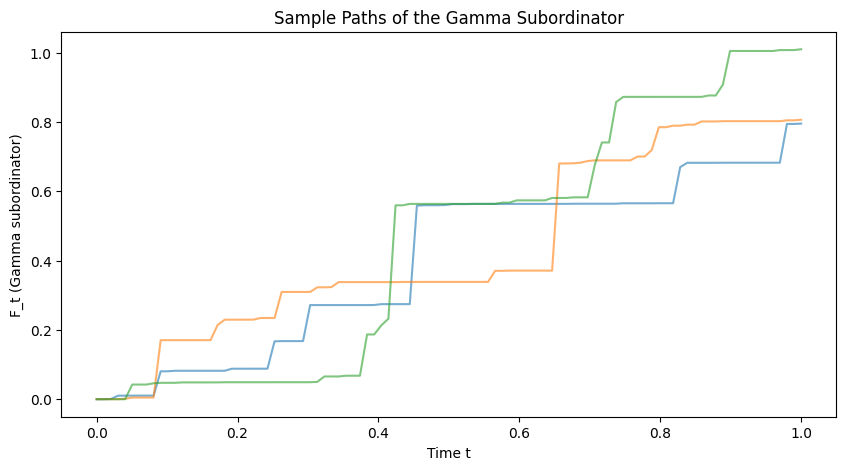

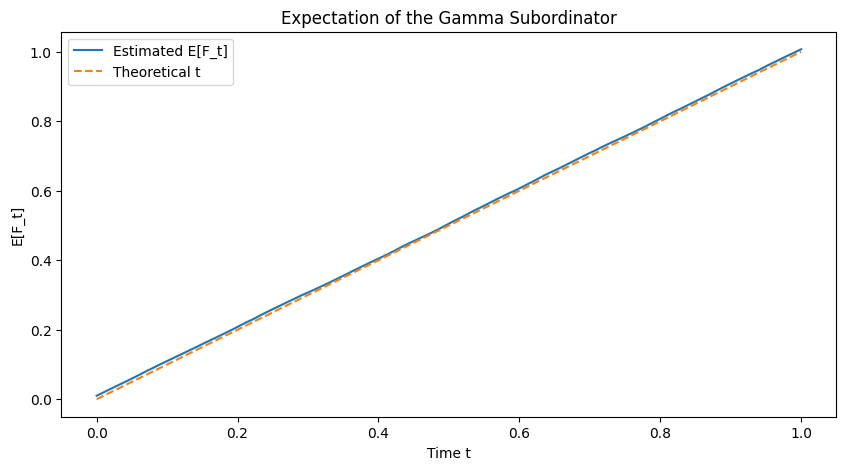

In [16]:
def gamma_process(T, theta, nu, N, M):
    dt = T / N  # Time step
    Ft = np.cumsum(np.random.gamma(shape=dt/nu, scale=nu, size=(M, N)), axis=1)  # Gamma increments
    return Ft

# Parameters
T = 1.0   # Total time
N = 100   # Number of time steps
M = 10000 # Number of simulations
theta = 0  # Drift (not relevant for subordinator)
nu = 0.2  # Variance scaling parameter

# Simulate the Gamma subordinator process
Ft = gamma_process(T, theta, nu, N, M)

time_grid = np.linspace(0, T, N)

# Plot sample paths
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.plot(time_grid, Ft[i], alpha=0.6)
plt.xlabel("Time t")
plt.ylabel("F_t (Gamma subordinator)")
plt.title("Sample Paths of the Gamma Subordinator")
plt.show()

# Verify expectation E[F_t] ≈ t
mean_Ft = np.mean(Ft, axis=0)
plt.figure(figsize=(10, 5))
plt.plot(time_grid, mean_Ft, label='Estimated E[F_t]')
plt.plot(time_grid, time_grid, linestyle='--', label='Theoretical t')
plt.xlabel("Time t")
plt.ylabel("E[F_t]")
plt.title("Expectation of the Gamma Subordinator")
plt.legend()
plt.show()